# Inference Script

**Author:** Prisca Dotti

**Last modified:** 26.10.2023

Used this script for the following purposes:
- Create video outputs
- Test new inference methods
- Calculate metrics for a saved model
- Evaluate new methods for assessing predictions

In the configuration file (.ini), modify the parameters in the "testing" section.


In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [2]:
import logging
import os

import torch
from torch import nn
from torch.utils.data import DataLoader

from config import TrainingConfig, config
from data.data_processing_tools import masks_to_instances_dict, process_raw_predictions
from utils.in_out_tools import write_videos_on_disk
from utils.training_inference_tools import do_inference
from utils.training_script_utils import get_sample_ids, init_dataset, init_model

logger = logging.getLogger(__name__)


config.verbosity = 3  # To get debug messages

In [4]:
####################### Get training-specific parameters #######################

run_name = "final_model"
# run_name = "TEMP_new_annotated_peaks_physio"  # TEMP local (run on laptop)
config_filename = "config_final_model.ini"
load_epoch = 100000

use_train_data = False
get_final_pred = True  # set to False to only compute raw predictions
# custom_ids = []
custom_ids = [
    "05",
    "10",
    "15",
    "20",
    "25",
    "32",
    "34",
    "40",
    "45",
]  # override sample_ids if needed

testing = True  # set to False to only generate unet predictions
# set to True to also compute processed outputs and metrics
# inference_types = ['overlap', 'average', 'gaussian', 'max']
inference_types = []  # set to empty to use the default inference type from
# the config file

# Initialize general parameters
params = TrainingConfig(
    training_config_file=os.path.join("config_files", config_filename)
)

if run_name:
    params.run_name = run_name
model_filename = f"network_{load_epoch:06d}.pth"

# Print parameters to console if needed
# params.print_params()

if testing:
    get_final_pred = True

debug = True if config.verbosity == 3 else False

[18:03:24] [  INFO  ] [   config   ] <290 > -- Loading C:\Users\dotti\sparks_project\config_files\config_final_model.ini


In [5]:
########################### Configure output folder ############################

output_folder = os.path.join(
    config.basedir, "evaluation", "inference_script"
)  # Same folder for train and test preds
os.makedirs(output_folder, exist_ok=True)

# Subdirectory of output_folder where predictions are saved.
# Change this to save results for same model with different inference
# approaches.
# output_name = training_name + "_step=2"
output_name = params.run_name

save_folder = os.path.join(config.basedir, output_folder, output_name)
os.makedirs(save_folder, exist_ok=True)
logger.info(f"Annotations and predictions will be saved on '{save_folder}'")

[18:04:33] [  INFO  ] [  __main__  ] < 16 > -- Annotations and predictions will be saved on 'C:\Users\dotti\sparks_project\evaluation\inference_script\final_model'


In [7]:
########################### Detect GPU, if available ###########################

params.set_device(device="auto")
# params.set_device(device="cpu")  # temporary
params.display_device_info()

[18:04:56] [  INFO  ] [   config   ] <528 > -- Using cuda


In [8]:
############################## Configure dataset ###############################

logger.info(f"Processing training '{params.run_name}'...")

# Define the sample IDs based on dataset size and usage
sample_ids = get_sample_ids(
    train_data=use_train_data,
    dataset_size=params.dataset_size,
    custom_ids=custom_ids,
)
logger.info(f"Predicting outputs for samples {sample_ids}.")
logger.info(f"Using {params.dataset_dir} as dataset root path.")

# Create dataset
dataset = init_dataset(
    params=params,
    sample_ids=sample_ids,
    apply_data_augmentation=False,
    print_dataset_info=True,
    load_instances=testing,
)

# Create a dataloader
dataset_loader = DataLoader(
    dataset,
    batch_size=params.inference_batch_size,
    shuffle=False,
    num_workers=params.num_workers,
    pin_memory=params.pin_memory,
)

[18:06:23] [  INFO  ] [  __main__  ] < 3  > -- Processing training 'final_model'...
[18:06:23] [  INFO  ] [  __main__  ] < 11 > -- Predicting outputs for samples ['05', '10', '15', '20', '25', '32', '34', '40', '45'].
[18:06:23] [  INFO  ] [  __main__  ] < 12 > -- Using C:\Users\dotti\sparks_project\data\sparks_dataset as dataset root path.
[18:07:00] [  INFO  ] [utils.training_script_utils] <137 > -- Samples in training dataset: 158


In [9]:
################################ Configure UNet ################################

network = init_model(params=params)

# Move the model to the GPU if available
if params.device.type != "cpu":
    network = nn.DataParallel(network).to(params.device, non_blocking=True)
    # cudnn.benchmark = True

### Load UNet model ###

# Path to the saved model checkpoint
models_relative_path = os.path.join(
    "models", "saved_models", params.run_name, model_filename
)
model_dir = os.path.realpath(os.path.join(config.basedir, models_relative_path))

# Load the model state dictionary
logger.info(f"Loading trained model '{run_name}' at epoch {load_epoch}...")
try:
    network.load_state_dict(torch.load(model_dir, map_location=params.device))
except RuntimeError as e:
    if "module" in str(e):
        # The error message contains "module," so handle the DataParallel loading
        logger.warning(
            "Failed to load the model, as it was trained with DataParallel. Wrapping it in DataParallel and retrying..."
        )
        # Get current device of the object (model)
        temp_device = next(iter(network.parameters())).device

        network = nn.DataParallel(network)
        network.load_state_dict(torch.load(model_dir, map_location=params.device))

        logger.info("Network should be on CPU, removing DataParallel wrapper...")
        network = network.module.to(temp_device)
    else:
        # Handle other exceptions or re-raise the exception if it's unrelated
        raise

[18:07:44] [  INFO  ] [  __main__  ] < 19 > -- Loading trained model 'final_model' at epoch 100000...


In [10]:
########################### Run samples in UNet ############################

if len(inference_types) == 0:
    inference_types = [params.inference]
else:
    inference_types = inference_types

# get U-Net's raw predictions
network.eval()
raw_preds = do_inference(
    network=network,
    params=params,
    dataloader=dataset_loader,
    device=params.device,
    compute_loss=False,
    inference_types=inference_types,
)

In [11]:
############# Get movies and labels (and instances if testing) #############

xs = dataset.get_movies()
ys = dataset.get_labels()

if testing:
    ys_instances = dataset.get_instances()

    # convert instance masks to dictionaries
    ys_instances = {
        i: masks_to_instances_dict(
            instances_mask=instances_mask,
            labels_mask=ys[i],
            shift_ids=True,
        )
        for i, instances_mask in ys_instances.items()
    }

    # remove ignored events entry from ys_instances
    for inference in ys_instances:
        ys_instances[inference].pop("ignore", None)

In [12]:
#################### Get processed output (if required) ####################

if get_final_pred:
    logger.debug("Getting processed output (segmentation and instances)")

    final_segmentation_dict = {}
    final_instances_dict = {}
    for i in range(len(sample_ids)):
        movie_segmentation = {}
        movie_instances = {}

        for inference in inference_types:
            # transform raw predictions into a dictionary
            raw_preds_dict = {
                event_type: raw_preds[i][inference][event_label]
                for event_type, event_label in config.classes_dict.items()
                if event_type in config.event_types
            }

            preds_instances, preds_segmentation, _ = process_raw_predictions(
                raw_preds_dict=raw_preds_dict,
                input_movie=xs[i],
                training_mode=False,
                debug=debug,
            )

            movie_segmentation[inference] = preds_segmentation
            movie_instances[inference] = preds_instances

        final_segmentation_dict[sample_ids[i]] = movie_segmentation
        final_instances_dict[sample_ids[i]] = movie_instances

else:
    final_segmentation_dict = {}
    final_instances_dict = {}

[18:15:04] [ DEBUG  ] [  __main__  ] < 4  > -- Getting processed output (segmentation and instances)
[18:15:04] [ DEBUG  ] [data.data_processing_tools] <529 > -- Events detection threshold: 0.494
[18:15:09] [ DEBUG  ] [data.data_processing_tools] <597 > -- Number of sparks detected by nonmaxima suppression: 130
[18:15:19] [ DEBUG  ] [data.data_processing_tools] <980 > -- Time for removing small events: 8.70 s
[18:15:19] [ DEBUG  ] [data.data_processing_tools] <529 > -- Events detection threshold: 0.494
[18:15:24] [ DEBUG  ] [data.data_processing_tools] <597 > -- Number of sparks detected by nonmaxima suppression: 34
[18:15:29] [ DEBUG  ] [data.data_processing_tools] <980 > -- Time for removing small events: 3.53 s
[18:15:29] [ DEBUG  ] [data.data_processing_tools] <529 > -- Events detection threshold: 0.498
[18:15:34] [ DEBUG  ] [data.data_processing_tools] <597 > -- Number of sparks detected by nonmaxima suppression: 30
[18:15:35] [ DEBUG  ] [data.data_processing_tools] <629 > -- Not 

In [13]:
############################ Save preds on disk ############################

logger.info(f"\tSaving annotations and predictions...")

for i, sample_id in enumerate(sample_ids):
    for inference in inference_types:
        video_name = f"{str(params.load_epoch)}_{sample_id}_{inference}"

        raw_preds_movie = raw_preds[i][inference]
        if get_final_pred:
            segmented_preds_movie = final_segmentation_dict[sample_id][inference]
            instances_preds_movie = final_instances_dict[sample_id][inference]
        else:
            segmented_preds_movie = None
            instances_preds_movie = None

        write_videos_on_disk(
            training_name=output_name,
            video_name=video_name,
            out_dir=os.path.join(save_folder, "inference_" + inference),
            # xs=xs[i], # xs is available elsewhere
            # ys=ys[i], # ys is available elsewhere
            raw_preds=raw_preds_movie,
            segmented_preds=segmented_preds_movie,
            instances_preds=instances_preds_movie,
        )

logger.info(f"DONE")

[18:18:09] [  INFO  ] [  __main__  ] < 3  > -- 	Saving annotations and predictions...
[18:18:09] [ DEBUG  ] [utils.in_out_tools] <188 > -- Writing videos on directory C:\Users\dotti\sparks_project\evaluation\inference_script\final_model\inference_overlap ..
[18:18:09] [ DEBUG  ] [utils.in_out_tools] <188 > -- Writing videos on directory C:\Users\dotti\sparks_project\evaluation\inference_script\final_model\inference_overlap ..
[18:18:09] [ DEBUG  ] [utils.in_out_tools] <188 > -- Writing videos on directory C:\Users\dotti\sparks_project\evaluation\inference_script\final_model\inference_overlap ..
[18:18:10] [ DEBUG  ] [utils.in_out_tools] <188 > -- Writing videos on directory C:\Users\dotti\sparks_project\evaluation\inference_script\final_model\inference_overlap ..
[18:18:10] [ DEBUG  ] [utils.in_out_tools] <188 > -- Writing videos on directory C:\Users\dotti\sparks_project\evaluation\inference_script\final_model\inference_overlap ..
[18:18:11] [ DEBUG  ] [utils.in_out_tools] <188 > -- W

## Visualize preds with Napari

- load given training at given iteration (testing section of config file) and visualize predictions using Napari
- (idea is to check if it makes sense to stop the training earlier)
- adapt dataset size (& other params) in config file prior to execute code above if necessary

Trainings already checked with this method:
- final_model (minimal dataset, only movie 34)
    - 10K; 20K; 30K; 40K: too many sparks, does not make sense (>2K after correction)
    - 50K: too many sparks, does not make sense (>1K after correction)
    - 60K: 72 sparks before correction/82 sparks after correction
    - 70K: 71/78 -> does not change much from 60K aesthetically
    - 80K: 53/55 -> same; in the end what matters is to chose the best metrics (I believe)
    - 90K: 51/55 -> same
    - 100K: 61/63 -> same

In [11]:
from utils.visualization_tools import (
    get_discrete_cmap,
    get_labels_cmap,
    get_annotations_contour,
)
import napari

In [3]:
cmap = get_discrete_cmap(name="gray", lut=16)

In [4]:
preds_classes = {}

i = 0
sample_id = sample_ids[i]

# get contours of annotations, for visualization
ys_contours = get_annotations_contour(annotations=ys[i], contour_val=2)

# get predicted segmentation and event instances
# _, raw_sparks, raw_waves, raw_puffs = preds[sample_id]
# preds_events = preds_instances[sample_id]

preds_classes[params.load_epoch] = (
    final_segmentation_dict[sample_id]["overlap"]["sparks"]
    + 3 * final_segmentation_dict[sample_id]["overlap"]["puffs"]
    + 2 * final_segmentation_dict[sample_id]["overlap"]["waves"]
)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(xs[i], name="raw", colormap=("colors", cmap))
viewer.add_labels(ys_contours, name="gt", opacity=0.5, color=get_labels_cmap())

# viewer.add_image(raw_sparks, name='raw_sparks')
# viewer.add_image(raw_waves, name='raw_waves')
# viewer.add_image(raw_puffs, name='raw_puffs')
for epoch in preds_classes.keys():
    viewer.add_labels(
        preds_classes[epoch],
        name=f"preds_{epoch}",
        opacity=0.3,
        color=get_labels_cmap(),
    )

[18:58:47] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering provider of <class 'napari.viewer.Viewer'>: <function _provide_viewer at 0x0000024F399B9750> (weight: 0, subclassable: True)
[18:58:47] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering provider of <class 'napari.layers.base.base.Layer'>: <function _provide_active_layer at 0x0000024F399B9AB0> (weight: 0, subclassable: True)
[18:58:47] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering provider of <class 'napari.components.layerlist.LayerList'>: <function _provide_active_layer_list at 0x0000024F399B9B40> (weight: 0, subclassable: True)
[18:58:47] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering processor of napari.types.LayerDataTuple: <function _add_layer_data_tuples_to_viewer at 0x0000024F399B9A20> (weight: 0, subclassable: False)
[18:58:47] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering processor of typing.List[napari.types.LayerDataTuple]: <function _add_layer_data_tuples_to_viewer at 0x0000024F399B9A20> (weight: 0, subclassable:

[18:58:48] [WARNING ] [   vispy    ] <234 > -- DirectWrite: CreateFontFaceFromHDC() failed (Indicates an error in an input file such as a font file.) for QFontDef(Family="", pointsize=12, pixelsize=16, styleHint=5, weight=50, stretch=100, hintingPreference=0) LOGFONT("MS Sans Serif", lfWidth=0, lfHeight=-16) dpi=144
[18:58:49] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering provider of <class 'napari._qt.qt_main_window.Window'>: <function init_qactions.<locals>._provide_window at 0x0000024F4333C700> (weight: 0, subclassable: True)
[18:58:49] [ DEBUG  ] [  in_n_out  ] <1093> -- Registering provider of <class 'napari._qt.qt_viewer.QtViewer'>: <function init_qactions.<locals>._provide_qt_viewer at 0x0000024F4CEC17E0> (weight: 0, subclassable: True)
[18:58:50] [ DEBUG  ] [  in_n_out  ] <768 > -- Executing @injected ViewerToggleAction.__init__.<locals>.get_current(viewer: napari.viewer.Viewer) with args: (), kwargs: {}
[18:58:50] [ DEBUG  ] [  in_n_out  ] <955 > -- Rebuilding provider map c

[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- ImageSlice.__init__
[18:58:57] [ DEBUG  ] [napari.loader] < 69 > -- 

## Compute metrics

REMARK: I didn't remove the first and last frames (which are ignored by loss function)

In [6]:
if not testing:
    print("!!!!!!!!! THE FOLLOWING CODE WON'T WORK !!!!!!!!!")

In [21]:
import numpy as np
import pandas as pd
from data.data_processing_tools import preds_dict_to_mask
from evaluation.metrics_tools import (
    compute_iou,
    get_score_matrix,
    get_matches_summary,
    get_metrics_from_summary,
    get_df_metrics,
    get_df_summary_events,
)

### Segmentation-based metrics (i.e., IoU)

In [18]:
# concatenate annotations and preds to compute segmentation-based metrics
ys_concat = []
preds_concat = {i: [] for i in inference_types}

for i, sample_id in enumerate(sample_ids):
    ys_concat.append(ys[i])

    for inference in inference_types:
        # get preds segmentation as integer array with values in [0, 1, 2, 3]
        temp_preds = preds_dict_to_mask(final_segmentation_dict[sample_id][inference])
        # here I could remove marginal frames
        preds_concat[inference].append(temp_preds)

ys_concat = np.concatenate(ys_concat)
preds_concat = {i: np.concatenate(preds_concat[i]) for i in inference_types}

# get masks for pixels labelled with 4
ignore_concat = ys_concat == 4

In [22]:
# compute intersection over union for each inference type
# (per class, average, and as binary classification)

iou_dict = {i: {} for i in inference_types}

for inference in inference_types:
    for event_type, event_label in config.classes_dict.items():
        if event_type not in config.event_types:
            continue
        class_ys = np.array(ys_concat == event_label)
        class_preds = np.array(preds_concat[inference] == event_label)

        iou_dict[inference][event_type] = compute_iou(
            ys_roi=class_ys, preds_roi=class_preds, ignore_mask=ignore_concat
        )

    # compute average iou
    iou_dict[inference]["average"] = np.mean(list(iou_dict[inference].values()))

    # compute binary classification iou
    iou_dict[inference]["binary"] = compute_iou(
        ys_roi=np.array(ys_concat != 0),
        preds_roi=np.array(preds_concat[inference] != 0),
        ignore_mask=ignore_concat,
    )

In [40]:
iou_dict

{'overlap': {'sparks': 0.18327243642180654,
  'waves': 0.13346902425583532,
  'puffs': 0.04079612492807612,
  'average': 0.119179195201906,
  'binary': 0.37450068210391163}}

In [23]:
pd.set_option("display.precision", 3)

# create dataframe where index is event type and columns are inference types
df_barplot = pd.DataFrame(iou_dict).T.T
df_barplot

,overlap
average,0.119
binary,0.375
puffs,0.041
sparks,0.183
waves,0.133


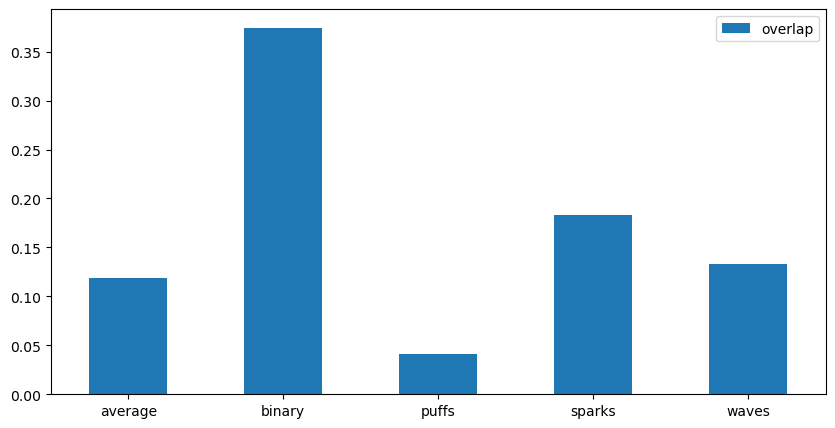

In [25]:
df_barplot.plot.bar(rot=0, figsize=(10, 5))

### Instance-based metrics

In [33]:
# sum events over all samples
preds_cat = ["tot", "tp", "ignored", "unlabeled"] + config.event_types
ys_cat = ["tot", "tp", "undetected"] + config.event_types

In [44]:
# initialize dicts that will contain the results
matched_preds_ids = {i: {} for i in inference_types}
matched_ys_ids = {i: {} for i in inference_types}

# initialize dicts that will contain the results for all samples (summed)
for inference in inference_types:
    matched_preds_ids[inference]["sum"] = {}
    matched_ys_ids[inference]["sum"] = {}
    for ca_event in config.event_types:
        matched_preds_ids[inference]["sum"][ca_event] = {
            cat: 0 for cat in preds_cat if cat != ca_event
        }
        matched_ys_ids[inference]["sum"][ca_event] = {
            cat: 0 for cat in ys_cat if cat != ca_event
        }

for i, sample_id in enumerate(sample_ids):
    logger.info(f"Processing sample {sample_id}...")

    # get ignore mask for this sample
    ignore_mask = ys[i] == 4

    # compute pairwise scores between annotated and predicted ROIs
    # (for each inference type)
    for inference in inference_types:
        logger.info(f"\tInference type {inference}...")
        iomin_scores = get_score_matrix(
            ys_instances=ys_instances[i],
            preds_instances=final_instances_dict[sample_id][inference],
            ignore_mask=np.array([]),
        )

        # get ids of matched ROIs
        (
            matched_ys_ids[inference][sample_id],
            matched_preds_ids[inference][sample_id],
        ) = get_matches_summary(
            ys_instances=ys_instances[i],
            preds_instances=final_instances_dict[sample_id][inference],
            scores=iomin_scores,
            ignore_mask=ignore_mask,
        )

        # count number of categorized events that are necessary for the metrics
        for ca_event in config.event_types:
            for cat in matched_ys_ids[inference][sample_id][ca_event].keys():
                matched_ys_ids[inference]["sum"][ca_event][cat] += len(
                    matched_ys_ids[inference][sample_id][ca_event][cat]
                )

            for cat in matched_preds_ids[inference][sample_id][ca_event].keys():
                matched_preds_ids[inference]["sum"][ca_event][cat] += len(
                    matched_preds_ids[inference][sample_id][ca_event][cat]
                )

[22:30:38] [  INFO  ] [  __main__  ] < 18 > -- Processing sample 34...
[22:30:38] [  INFO  ] [  __main__  ] < 26 > -- 	Inference type overlap...


In [45]:
# get dict that only contains sum over all samples
tot_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["tot"]
        for ca_class in config.event_types
    }
    for i in inference_types
}
tp_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["tp"]
        for ca_class in config.event_types
    }
    for i in inference_types
}
ignored_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["ignored"]
        for ca_class in config.event_types
    }
    for i in inference_types
}
unlabeled_preds = {
    i: {
        ca_class: matched_preds_ids[i]["sum"][ca_class]["unlabeled"]
        for ca_class in config.event_types
    }
    for i in inference_types
}
tot_ys = {
    i: {
        ca_class: matched_ys_ids[i]["sum"][ca_class]["tot"]
        for ca_class in config.event_types
    }
    for i in inference_types
}
tp_ys = {
    i: {
        ca_class: matched_ys_ids[i]["sum"][ca_class]["tp"]
        for ca_class in config.event_types
    }
    for i in inference_types
}
undetected_ys = {
    i: {
        ca_class: matched_ys_ids[i]["sum"][ca_class]["undetected"]
        for ca_class in config.event_types
    }
    for i in inference_types
}


metrics_all = {i: {} for i in inference_types}

# get other metrics (precision, recall, % correctly classified, % detected)
for inference in inference_types:
    metrics_all[inference] = get_metrics_from_summary(
        tot_preds=tot_preds[inference],
        tp_preds=tp_preds[inference],
        ignored_preds=ignored_preds[inference],
        unlabeled_preds=unlabeled_preds[inference],
        tot_ys=tot_ys[inference],
        tp_ys=tp_ys[inference],
        undetected_ys=undetected_ys[inference],
    )

In [46]:
# Compute same metrics but as % instead of absolute numbers
matched_preds_percent = {
    i: {ca_event: {} for ca_event in config.event_types} for i in inference_types
}
matched_ys_percent = {
    i: {ca_event: {} for ca_event in config.event_types} for i in inference_types
}

for inference in inference_types:
    for ca_event in config.event_types:
        for cat in matched_preds_ids[inference]["sum"][ca_event].keys():
            if cat != "tot":
                matched_preds_percent[inference][ca_event][cat] = (
                    matched_preds_ids[inference]["sum"][ca_event][cat]
                    / matched_preds_ids[inference]["sum"][ca_event]["tot"]
                    * 100
                )

        for cat in matched_ys_ids[inference]["sum"][ca_event].keys():
            if cat != "tot":
                matched_ys_percent[inference][ca_event][cat] = (
                    matched_ys_ids[inference]["sum"][ca_event][cat]
                    / matched_ys_ids[inference]["sum"][ca_event]["tot"]
                    * 100
                )

In [62]:
print("Summary of detected events")
for inference in inference_types:
    df = get_df_summary_events(
        inference_type=inference,
        matched_ids=matched_preds_ids,
        matched_percent=matched_preds_percent,
        is_detected=True,
    )
    # Format the DataFrame
    styled_df = df.style.format(precision=2, na_rep="N/A")
    print(f"{inference} inference")
    display(styled_df)

print("Summary of labeled events")
for inference in inference_types:
    df = get_df_summary_events(
        inference_type=inference,
        matched_ids=matched_ys_ids,
        matched_percent=matched_ys_percent,
        is_detected=False,
    )
    # Format the DataFrame
    styled_df = df.style.format(precision=2, na_rep="N/A")
    print(f"{inference} inference")
    display(styled_df)

Summary of detected events
overlap inference


,sparks,waves,puffs,% sparks,% waves,% puffs
Total Detected,57,2,21,N/A,N/A,N/A
ignored,2,0,1,3.51,0.00,4.76
unlabeled,11,0,10,19.30,0.00,47.62
Matched with Detected Waves,30,2,7,52.63,100.00,33.33
Matched with Detected Puffs,1,0,1,1.75,0.00,4.76
Matched with Detected Sparks,13,0,2,22.81,0.00,9.52


Summary of labeled events
overlap inference


,sparks,waves,puffs,% sparks,% waves,% puffs
Total Labeled,16,5,3,N/A,N/A,N/A
undetected,2,1,1,12.50,20.00,33.33
Matched with Labeled Waves,0,2,0,0.00,40.00,0.00
Matched with Labeled Puffs,2,4,1,12.50,80.00,33.33
Matched with Labeled Sparks,13,4,1,81.25,80.00,33.33


In [63]:
for inference in inference_types:
    df = get_df_metrics(inference_type=inference, metrics_all=metrics_all)
    # Set the display precision to 2 decimal places
    pd.set_option("display.precision", 2)
    # Format the DataFrame
    styled_df = df.style.format(precision=2)
    print(f"Metrics using {inference} inference")
    display(styled_df)

Metrics using overlap inference


,precision,recall,correctly_classified,detected
sparks,0.24,0.81,0.30,0.88
waves,1.00,0.40,1.00,0.80
puffs,0.05,0.33,0.10,0.67
average,0.43,0.52,0.47,0.78


## Visualize other properties of data...

In [64]:
import matplotlib.pyplot as plt

### Plot histograms of raw predictions

In [ ]:
# concatenate annotations and preds to compute segmentation-based metrics
ys_concat = []
preds_concat = {i: [] for i in inference_types}

for i, sample_id in enumerate(sample_ids):
    ys_concat.append(ys[i])

    for inference in inference_types:
        # get preds segmentation as integer array with values in [0, 1, 2, 3]
        temp_preds = preds_dict_to_mask(final_segmentation_dict[sample_id][inference])
        # here I could remove marginal frames
        preds_concat[inference].append(temp_preds)

ys_concat = np.concatenate(ys_concat)
preds_concat = {i: np.concatenate(preds_concat[i]) for i in inference_types}

# get masks for pixels labelled with 4
ignore_concat = ys_concat == 4

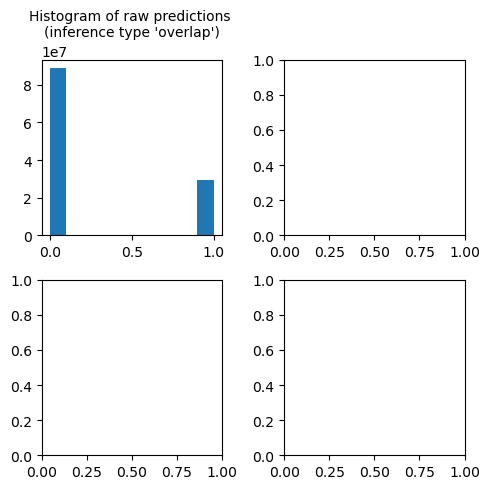

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

for inference, ax in zip(inference_types, axs.flatten()):
    # concatenate raw predictions
    raw_preds_concat = [raw_preds[i][inference] for i, _ in enumerate(sample_ids)]
    raw_preds_concat = np.concatenate(raw_preds_concat, axis=1)

    ax.hist(raw_preds_concat.flatten(), bins=10)
    ax.set_title(
        f"Histogram of raw predictions \n(inference type '{inference}')", fontsize=10.0
    )

fig.tight_layout()

### code to try and visualize different types of inference

In [ ]:
# ## DEBUG ###

# test_dataset = SparkDataset(
#         base_path=dataset_path,
#         sample_ids=['34'],
#         testing=testing,
#         smoothing=c.get("dataset", "data_smoothing"),
#         step=c.getint("testing", "data_stride"),
#         #step=2,
#         duration=c.getint("testing", "data_duration"),
#         remove_background=c.get("dataset", "remove_background"),
#         temporal_reduction=c.getboolean(
#             "network", "temporal_reduction", fallback=False
#         ),
#         num_channels=c.getint("network", "num_channels", fallback=1),,
#         normalize_video=c.get("dataset", "norm_video"),
#         only_sparks=c.getboolean("dataset", "only_sparks", fallback=False),
#         sparks_type=c.get("dataset", "sparks_type"),
#         ignore_frames=c.getint("training", "ignore_frames_loss"),
#         ignore_index=4,
#         gt_available=True,
#         inference=inference,
#     )

# testing_dataloader = torch.utils.data.DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True,
# )

# from training_inference_tools import do_inference

# test_dataset.inference = 'overlap'
# pred_overlap = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )


# test_dataset.inference = 'average'
# pred_average = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# test_dataset.inference = 'max'
# pred_max = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# test_dataset.inference = 'gaussian'
# pred_gaussian = do_inference(network=network,
#                             test_dataset=test_dataset,
#                             test_dataloader=testing_dataloader,
#                             device=device,
#                             )

# pred_overlap.shape, pred_average.shape, pred_max.shape, pred_gaussian.shape
# empty_vertical = np.ones((pred_overlap.shape[0],
#                           pred_overlap.shape[1],
#                           pred_overlap.shape[2],
#                           10))*0.5

# empty_horizontal = np.ones((pred_overlap.shape[0],
#                             pred_overlap.shape[1],
#                             10,
#                             2*pred_overlap.shape[3]+10))*0.5
# # stack the four predictions togheter in a squared grid

# stack1 = np.concatenate((pred_overlap, empty_vertical, pred_average), axis=3)
# stack2 = np.concatenate((pred_max, empty_vertical, pred_gaussian), axis=3)

# stack_all = np.concatenate((stack1, empty_horizontal, stack2), axis=2)
# import napari
# viewer = napari.Viewer()
# viewer.theme = 'dark'

# viewer.add_image(stack_all[0],
#                  name='background',
#                     #colormap='white',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[1],
#                     name='sparks',
#                     colormap='green',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[2],
#                     name='waves',
#                     colormap='yellow',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

# viewer.add_image(stack_all[3],
#                     name='puffs',
#                     colormap='red',
#                     blending='additive',
#                     opacity=0.5,
#                     #visible=False,
#                 )

### code to visualize a confusion matrix (OLD)

In [ ]:
# plt.rcParams.update({"font.size": 24})

# n_rows = 1
# n_cols = 1
# num_plots = n_rows * n_cols

# pad = 5  # in points

# fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 100))

# cols = ["IoU"]
# tick_labels = ["Background", "Sparks", "Waves", "Puffs"]

# for ax, col in zip(axs[0], cols):
#     ax.annotate(
#         col,
#         xy=(0.5, 1.2),
#         xytext=(0, pad),
#         xycoords="axes fraction",
#         textcoords="offset points",
#         size="large",
#         ha="center",
#         va="baseline",
#     )


# for ax, row in zip(axs[:, 0], ["TOT"] + movie_ids):
#     ax.annotate(
#         row,
#         xy=(0, 0.5),
#         xytext=(-ax.yaxis.labelpad - pad, 0),
#         xycoords=ax.yaxis.label,
#         textcoords="offset points",
#         size="large",
#         ha="right",
#         va="center",
#     )

# fig.suptitle("Confusion matrices", fontsize=36, y=1)


# # configure heatmap background
# colors = sns.color_palette(
#     ["white", "lightcoral", "paleturquoise", "lemonchiffon", "lightgreen"], as_cmap=True
# )
# colored_bg = [[0, 2, 2, 2], [1, 4, 3, 3], [1, 3, 4, 3], [1, 3, 3, 4]]

# # Get array with confusion matrices to be plotted
# cm_array = np.concatenate(
#     (
#         [[iou_confusion_matrix_tot, iomin_confusion_matrix_tot]],
#         [
#             [iou_confusion_matrix[sample_id], iomin_confusion_matrix[sample_id]]
#             for sample_id in movie_ids
#         ],
#     ),
#     axis=0,
# )

# for row_id in range(n_rows):
#     for col_id in range(n_cols):
#         cm = cm_array[row_id, col_id].astype(int).astype(str)

#         ax = axs[row_id, col_id]
#         sns.heatmap(
#             data=colored_bg,
#             cmap=colors,
#             annot=cm,
#             fmt="",
#             annot_kws={"fontsize": 36},
#             cbar=False,
#             square=True,
#             ax=ax,
#         )

#         ax.tick_params(length=0, labeltop=True, labelbottom=False)
#         ax.tick_params(axis="both", which="major", pad=16)

#         ax.set_xlabel("Predicted", labelpad=32)
#         ax.xaxis.set_label_position("top")
#         ax.set_xticklabels(tick_labels)
#         ax.add_patch(
#             plt.Rectangle(
#                 (-0.01, 1),
#                 1.01,
#                 0.1,
#                 color="yellow",
#                 clip_on=False,
#                 zorder=0,
#                 transform=ax.transAxes,
#             )
#         )

#         ax.set_ylabel("Actual Values", labelpad=32)
#         ax.set_yticklabels(tick_labels, rotation=90, va="center")
#         ax.add_patch(
#             plt.Rectangle(
#                 (0, 0),
#                 -0.1,
#                 1,
#                 color="yellow",
#                 clip_on=False,
#                 zorder=0,
#                 transform=ax.transAxes,
#             )
#         )

# # plt.subplots_adjust(hspace=0.005, wspace=0.)
# # plt.subplots_adjust(hspace=0.1, wspace=0.1, top=0.9, left=0.05, right=0.95)
# # fig.subplots_adjust(left=0.15, top=0.95)
# fig.subplots_adjust(wspace=1.5)
# plt.tight_layout()
# plt.savefig(os.path.join(out_dir, "all_confusion_matrices.png"))
# plt.show()